In [4]:
!pip install prince

In [2]:
import pandas as pd
import numpy as np
import prince

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kruskal
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [5]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Clean_Dataset2.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["class"]
)

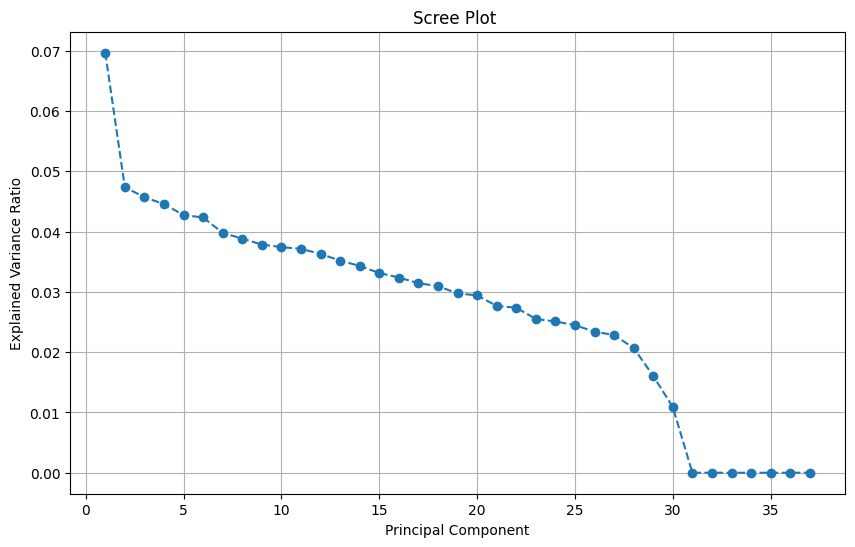

In [7]:
# 2. Stratified Subsetting (Consider class for sampling)
# We select 15000 samples, maintaining the class ratio.
subset_df, _ = train_test_split(
    train_df,
    train_size=15000,
    stratify=train_df['class'],
    random_state=42
)

# 3. Drop Features (Price, Flight, Class)
subset_df_dropped = subset_df.drop(['price', 'flight'], axis=1)

# 4. FAMD Preprocessing
numeric_cols = subset_df_dropped.select_dtypes(include=[np.number]).columns
categorical_cols = subset_df_dropped.select_dtypes(include=['object', 'category']).columns

# Scale Numeric
scaler = StandardScaler()
X_num = scaler.fit_transform(subset_df_dropped[numeric_cols])
# Fix: Assign original numeric column names to the scaled numerical DataFrame
X_num_df = pd.DataFrame(X_num, columns=numeric_cols, index=subset_df_dropped.index)

# Scale Categorical (FAMD)
encoder = OneHotEncoder(sparse_output=False)
X_cat = encoder.fit_transform(subset_df_dropped[categorical_cols])
X_cat_df = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(), index=subset_df_dropped.index)

# Weight by inverse sqrt of probability
p = X_cat_df.mean()
X_cat_scaled = (X_cat_df - p) / np.sqrt(p)

# Combine
X_final = pd.concat([X_num_df, X_cat_scaled], axis=1)

# 5. PCA and Elbow Plot
pca = PCA()
pca.fit(X_final)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot ')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

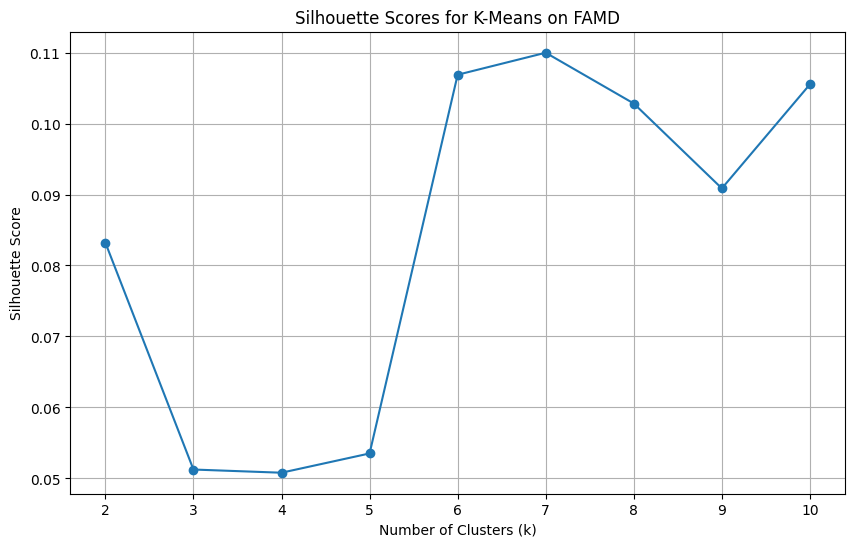

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define famd_data as the PCA-transformed data from X_final
famd_data = pca.transform(X_final)

# 1. Compute Silhouette Scores for k=2 to 10
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(famd_data)
    score = silhouette_score(famd_data, labels)
    silhouette_scores.append(score)

# 2. Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Scores for K-Means on FAMD')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


In [8]:
# ==========================================
# STEP 0: INITIAL CLEANUP
# ==========================================
print("\n--- Step 0: Dropping Useless ID Columns ---")

# List of columns to drop immediately
# 'flight': Just an ID, acts like a name, contains no pattern info
cols_to_drop = ['flight']

# Drop from Training Data
# (Assuming your dataframe is named 'train_df' or 'df')
if 'flight' in train_df.columns:
    train_df = train_df.drop(columns=cols_to_drop, errors='ignore')
    print("Dropped 'flight' from Training Data.")

# Drop from Test Data
if 'flight' in test_df.columns:
    test_df = test_df.drop(columns=cols_to_drop, errors='ignore')
    print("Dropped 'flight' from Test Data.")

# Verify
print(f"Train Shape: {train_df.shape}")
print(f"Test Shape:  {test_df.shape}")


--- Step 0: Dropping Useless ID Columns ---
Dropped 'flight' from Training Data.
Dropped 'flight' from Test Data.
Train Shape: (80000, 10)
Test Shape:  (20000, 10)


In [9]:
import numpy as np
import pandas as pd

print("\n--- Step 1: Transformations & Encoding (Updated with Route) ---")

def preprocess_data(data):
    data = data.copy()

    # --- NEW: Create Route & Drop Cities ---
    # 1. Combine Source and Destination into a single 'route' column
    # We add an underscore "_" to make it readable (e.g., "Delhi_Mumbai")
    data['route'] = data['source_city'] + "_" + data['destination_city']

    # 2. Drop the original city columns so they are not used in the model
    data = data.drop(columns=['source_city', 'destination_city'], errors='ignore')
    # ---------------------------------------

    # 3. Log Transformations (Creating the ingredients for Linear Models)
    if 'price' in data.columns:
        data['price_log'] = np.log1p(data['price'])

    data['duration_log'] = np.log1p(data['duration'])
    data['days_left_log'] = np.log1p(data['days_left'])

    # 4. Ordinal Encoding for 'stops' (Manual mapping)
    stops_mapping = {'zero': 0, 'one': 1, 'two_or_more': 2}
    if 'stops' in data.columns:
        data['stops_num'] = data['stops'].map(stops_mapping)
        data = data.drop(columns=['stops'], errors='ignore')

    # 5. One-Hot Encoding
    # Now that we added 'route' and dropped cities, this will automatically
    # encode 'route' instead of the cities.
    cat_cols = data.select_dtypes(include=['object']).columns.tolist()

    # Create dummy variables (0/1)
    data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

    return data

# Apply transformations to the training and test sets
df_train_final = preprocess_data(train_df)
df_test_final = preprocess_data(test_df)

# Add a 'set_type' column for tracking
df_train_final['set_type'] = 'train'
df_test_final['set_type'] = 'test'

print("\nFinal Train Shape:", df_train_final.shape)
print("Final Test Shape:", df_test_final.shape)

# Quick check
print("\nCheck for columns:")
# We check if 'route' was successfully encoded.
# There should be columns starting with "route_" now.
route_cols = [col for col in df_train_final.columns if 'route_' in col]
print(f"Number of Route columns created: {len(route_cols)}")
print(f"Example Route column: {route_cols[0] if route_cols else 'None'}")


--- Step 1: Transformations & Encoding (Updated with Route) ---

Final Train Shape: (80000, 53)
Final Test Shape: (20000, 53)

Check for columns:
Number of Route columns created: 29
Example Route column: route_Bangalore_Delhi


In [10]:
# ==========================================
# 2. ENCODING CATEGORICAL VARIABLES (Updated for Route)
# ==========================================
print("\n--- Step 2: Encoding Categorical Variables ---")
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def encode_data(train, test):
    # We combine them temporarily to ensure all categories are captured
    train['dataset'] = 'train'
    test['dataset'] = 'test'

    combined = pd.concat([train, test], axis=0)

    # 1. Label Encode Binary/Ordinal Columns
    # 'class': Economy=0, Business=1
    le = LabelEncoder()
    if 'class' in combined.columns:
        combined['class'] = le.fit_transform(combined['class'])
        print("Class Encoding Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

    # 2. One-Hot Encode Nominal Columns
    # --- UPDATE: Added 'route', Removed 'source_city' & 'destination_city' ---
    nominal_cols = ['airline', 'route', 'departure_time', 'arrival_time']

    # Only encode columns that actually exist in the dataframe
    # (If you already encoded them in Step 1, this will simply skip them)
    existing_cols = [c for c in nominal_cols if c in combined.columns]

    if existing_cols:
        print(f"One-Hot Encoding columns in this step: {existing_cols}")
        combined = pd.get_dummies(combined, columns=existing_cols, drop_first=True)
    else:
        print("No categorical text columns found to encode (likely done in Step 1).")

    # Split back into Train, Test
    train_enc = combined[combined['dataset'] == 'train'].drop(columns=['dataset'])
    test_enc = combined[combined['dataset'] == 'test'].drop(columns=['dataset'])

    return train_enc, test_enc

# Apply Encoding
# (Assumes df_train_final/df_test_final come from Step 1)
df_train_enc, df_test_enc = encode_data(df_train_final, df_test_final)

# Final Check
print("\nEncoding Complete.")
print(f"Train Shape: {df_train_enc.shape}")
print(f"Test Shape: {df_test_enc.shape}")

# Preview columns to verify we have everything
print("\nColumns available:", df_train_enc.columns.tolist())


--- Step 2: Encoding Categorical Variables ---
No categorical text columns found to encode (likely done in Step 1).

Encoding Complete.
Train Shape: (80000, 53)
Test Shape: (20000, 53)

Columns available: ['duration', 'days_left', 'price', 'price_log', 'duration_log', 'days_left_log', 'stops_num', 'airline_Air_India', 'airline_GO_FIRST', 'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara', 'departure_time_Early_Morning', 'departure_time_Evening', 'departure_time_Late_Night', 'departure_time_Morning', 'departure_time_Night', 'arrival_time_Early_Morning', 'arrival_time_Evening', 'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night', 'class_Economy', 'route_Bangalore_Delhi', 'route_Bangalore_Hyderabad', 'route_Bangalore_Kolkata', 'route_Bangalore_Mumbai', 'route_Chennai_Bangalore', 'route_Chennai_Delhi', 'route_Chennai_Hyderabad', 'route_Chennai_Kolkata', 'route_Chennai_Mumbai', 'route_Delhi_Bangalore', 'route_Delhi_Chennai', 'route_Delhi_Hyderabad', 'route_Delhi_Ko

In [11]:
# ==========================================
# 3. SPLITTING & HANDLING FEATURE SETS (Fixed with Stratify)
# ==========================================
print("\n--- Step 3: Splitting & Leakage Removal ---")
from sklearn.model_selection import train_test_split

# A. Separate Target (y) from Features (X)
# -------------------------------------------------------
y = df_train_enc['price_log']

# Initial X
X = df_train_enc.drop(columns=['price_log', 'price', 'set_type'], errors='ignore')

# B. Train-Test Split (80% Train, 20% Eval) - NOW STRATIFIED
# -------------------------------------------------------
# We stratify on 'class' to keep the Economy/Business balance perfect.
X_train_full, X_eval_full, y_train, y_eval = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=df_train_enc['class_Economy']  # <--- THIS IS THE FIX
)

# C. Create Specific Feature Sets
# -------------------------------------------------------

# 1. Set A: For LINEAR Models (MLR, Lasso)
drop_for_linear = ['duration', 'days_left']
X_train_linear = X_train_full.drop(columns=drop_for_linear, errors='ignore')
X_eval_linear = X_eval_full.drop(columns=drop_for_linear, errors='ignore')

# 2. Set B: For TREE Models (XGBoost, RF)
drop_for_trees = ['duration_log', 'days_left_log']
X_train_tree = X_train_full.drop(columns=drop_for_trees, errors='ignore')
X_eval_tree = X_eval_full.drop(columns=drop_for_trees, errors='ignore')

# --- Verification ---
print(f"Original Shape:   {X_train_full.shape}")
print(f"Linear Set Shape: {X_train_linear.shape}")
print(f"Tree Set Shape:   {X_train_tree.shape}")

# Verify Stratification worked
print("\nStratification Check (Class Mean):")
print(f"Full Train Class Mean: {df_train_enc['class_Economy'].mean():.4f}")
print(f"Sub-Train Class Mean:  {X_train_linear['class_Economy'].mean():.4f} (Should match above)")
print(f"Validation Class Mean: {X_eval_linear['class_Economy'].mean():.4f} (Should match above)")


--- Step 3: Splitting & Leakage Removal ---
Original Shape:   (64000, 50)
Linear Set Shape: (64000, 48)
Tree Set Shape:   (64000, 48)

Stratification Check (Class Mean):
Full Train Class Mean: 0.6885
Sub-Train Class Mean:  0.6885 (Should match above)
Validation Class Mean: 0.6886 (Should match above)


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 1. Stratified Sampling (10% to save RAM)
df_sample, _ = train_test_split(
    df,
    train_size=0.1,
    stratify=df['class'],
    random_state=42
)

# 2. Select Features
# We drop 'price', 'flight' (ID), and individual cities because 'route' replaces them
drop_cols = ['price', 'flight', 'source_city', 'destination_city']
X = df_sample.drop(columns=drop_cols, errors='ignore')

# 3. Encoding and Scaling
X = pd.get_dummies(X, drop_first=True, dtype=float)

scaler = StandardScaler()
num_cols = X.select_dtypes(include=['number']).columns
X[num_cols] = scaler.fit_transform(X[num_cols])

# 4. Add Constant
X = add_constant(X)

# 5. Calculate VIF
vif_list = []
for i in range(X.shape[1]):
    try:
        vif = variance_inflation_factor(X.values, i)
        vif_list.append(vif)
    except:
        vif_list.append(np.inf)

# 6. Display Top 10 Results
vif_df = pd.DataFrame({'feature': X.columns, 'VIF': vif_list})
vif_df = vif_df[vif_df['feature'] != 'const'] # Hide the constant

# Sort by VIF descending and show top 10
top_10_vif = vif_df.sort_values(by="VIF", ascending=False).head(10)
print(top_10_vif)

                         feature  VIF
7                airline_Vistara 6.01
3              airline_Air_India 5.19
5                 airline_Indigo 3.35
19            arrival_time_Night 2.44
4               airline_GO_FIRST 2.32
16          arrival_time_Evening 2.32
18          arrival_time_Morning 2.18
9         departure_time_Evening 2.00
8   departure_time_Early_Morning 1.97
11        departure_time_Morning 1.95


In [20]:
# 1. Sort and take the Top 10
vif_top_10 = vif_df.sort_values(by="VIF", ascending=False).head(10).reset_index(drop=True)

# 2. Apply the background gradient
# We use 'YlOrRd' (Yellow-Orange-Red) to highlight higher VIF values
beautiful_vif = vif_top_10.style.background_gradient(cmap='YlOrRd', subset=['VIF']) \
    .set_caption("Top 10 Multicollinearity Analysis (VIF)") \
    .format({'VIF': "{:.2f}"}) # Rounds to 2 decimal places

# Display the table
beautiful_vif

,feature,VIF
0,airline_Vistara,6.01
1,airline_Air_India,5.19
2,airline_Indigo,3.35
3,arrival_time_Night,2.44
4,airline_GO_FIRST,2.32
5,arrival_time_Evening,2.32
6,arrival_time_Morning,2.18
7,departure_time_Evening,2.00
8,departure_time_Early_Morning,1.97
9,departure_time_Morning,1.95


In [21]:
# ==========================================
# 4. SCALING (StandardScaler)
# ==========================================
print("\n--- Step 4: Scaling for Linear Models ---")
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# We only scale the 'Linear' set (MLR, Lasso).
scaler = StandardScaler()

# --- 1. Identify and drop columns that are entirely NaN ---
all_nan_cols = X_train_linear.columns[X_train_linear.isnull().all()]
if not all_nan_cols.empty:
    print(f"Dropping {len(all_nan_cols)} columns that are entirely NaN.")
    X_train_linear = X_train_linear.drop(columns=all_nan_cols, axis=1)
    X_eval_linear = X_eval_linear.drop(columns=all_nan_cols, axis=1)

# --- 2. Drop columns with Zero Standard Deviation ---
# (Crucial for One-Hot Encoded 'Route' variables that might be rare)
numeric_cols = X_train_linear.select_dtypes(include=np.number).columns
zero_std_cols = numeric_cols[X_train_linear[numeric_cols].std() == 0]

if not zero_std_cols.empty:
    print(f"Dropping {len(zero_std_cols)} columns with zero variance (all 0s or 1s).")
    X_train_linear = X_train_linear.drop(columns=zero_std_cols, axis=1)
    X_eval_linear = X_eval_linear.drop(columns=zero_std_cols, axis=1)

# --- 3. Impute remaining NaNs with Mean ---
# (Safety net for any stray missing values)
for col in X_train_linear.columns:
    if X_train_linear[col].isnull().any():
        mean_val = X_train_linear[col].mean()
        if np.isnan(mean_val): mean_val = 0 # Fallback

        X_train_linear[col] = X_train_linear[col].fillna(mean_val)
        X_eval_linear[col] = X_eval_linear[col].fillna(mean_val)

# --- 4. Apply Scaling ---
# Fit on TRAIN, Transform on EVAL
X_train_linear_scaled = scaler.fit_transform(X_train_linear)
X_eval_linear_scaled = scaler.transform(X_eval_linear)

# Convert back to DataFrame for readability
X_train_linear_scaled = pd.DataFrame(X_train_linear_scaled, columns=X_train_linear.columns)
X_eval_linear_scaled = pd.DataFrame(X_eval_linear_scaled, columns=X_eval_linear.columns)

print("Data Scaled Successfully.")
print(f"Final Shape: {X_train_linear_scaled.shape}")

# Check how many Route variables are left
route_cols_left = [c for c in X_train_linear_scaled.columns if 'route' in c]
print(f"Number of 'Route' features used in model: {len(route_cols_left)}")


--- Step 4: Scaling for Linear Models ---
Data Scaled Successfully.
Final Shape: (64000, 48)
Number of 'Route' features used in model: 29


In [22]:
# ==========================================
# 5. MODEL BUILDING (MLR)
# ==========================================
print("\n--- Step 5: Model Building (MLR) ---")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# 1. Train Linear Regression
# We use the SCALED LINEAR set (which now contains 'Route' features)
lr = LinearRegression()
lr.fit(X_train_linear_scaled, y_train)

# 2. Evaluate on the Evaluation (Validation) Set
pred_log = lr.predict(X_eval_linear_scaled)

# 3. Inverse Log for Real Error (Rupees)
pred_real = np.expm1(pred_log)
actual_real = np.expm1(y_eval)

# 4. Metrics
r2 = r2_score(actual_real, pred_real)
mae = mean_absolute_error(actual_real, pred_real)
rmse = np.sqrt(mean_squared_error(actual_real, pred_real))

print(f"\n--- MLR Performance (on Validation Set) ---")
print(f"R2 Score: {r2:.4f}")
print(f"MAE:      {mae:.2f}")
print(f"RMSE:     {rmse:.2f}")

# 5. Show Top Coefficients
# Since data is scaled, these coefficients are directly comparable!
print("\n--- Top Price Drivers (Scaled Coefficients) ---")
coefs = pd.Series(lr.coef_, index=X_train_linear.columns)

print("Top 5 Increasers (+): (Routes/Variables that spike the price)")
print(coefs.nlargest(5))

print("\nTop 5 Reducers (-): (Routes/Variables that lower the price)")
print(coefs.nsmallest(5))


--- Step 5: Model Building (MLR) ---

--- MLR Performance (on Validation Set) ---
R2 Score: 0.8595
MAE:      4670.27
RMSE:     8496.91

--- Top Price Drivers (Scaled Coefficients) ---
Top 5 Increasers (+): (Routes/Variables that spike the price)
airline_Vistara     0.32
airline_Air_India   0.23
stops_num           0.13
airline_Indigo      0.12
airline_GO_FIRST    0.12
dtype: float64

Top 5 Reducers (-): (Routes/Variables that lower the price)
class_Economy                -0.94
days_left_log                -0.21
route_Chennai_Hyderabad      -0.02
arrival_time_Early_Morning   -0.02
route_Mumbai_Hyderabad       -0.02
dtype: float64


In [23]:
# ==========================================
# MLR Model Performance Table (Ready for Route Data)
# ==========================================
print("\n--- MLR Model Performance ---")

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Helper function for MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

# Prepare actual values in real scale
# (derived from the splits in Step 3)
actual_train_real = np.expm1(y_train)
actual_test_real = np.expm1(y_eval)

# --- MLR Model (from lr object) ---

# 1. Predictions
# We use the SCALED LINEAR set which now contains 'Route' features
pred_train_log_mlr = lr.predict(X_train_linear_scaled)
pred_test_log_mlr = lr.predict(X_eval_linear_scaled)

# 2. Inverse transform to real scale
pred_train_real_mlr = np.expm1(pred_train_log_mlr)
pred_test_real_mlr = np.expm1(pred_test_log_mlr)

# 3. Metrics Calculation
train_rmse_mlr = np.sqrt(mean_squared_error(actual_train_real, pred_train_real_mlr))
train_r2_mlr = r2_score(actual_train_real, pred_train_real_mlr)
train_mape_mlr = calculate_mape(actual_train_real, pred_train_real_mlr)

test_rmse_mlr = np.sqrt(mean_squared_error(actual_test_real, pred_test_real_mlr))
test_r2_mlr = r2_score(actual_test_real, pred_test_real_mlr)
test_mape_mlr = calculate_mape(actual_test_real, pred_test_real_mlr)

# Calculate Adjusted R2 Score for MLR on TRAINING data
# Note: p_train will be larger now due to the many 'Route' dummy variables
n_train = X_train_linear_scaled.shape[0]
p_train = X_train_linear_scaled.shape[1]
adjusted_r2_train_mlr = 1 - (1 - train_r2_mlr) * (n_train - 1) / (n_train - p_train - 1)

# 4. Compile results
mlr_performance_row = {
    'Model Name': 'MLR',
    'Train RMSE': train_rmse_mlr,
    'Train MAPE': train_mape_mlr,
    'Test RMSE': test_rmse_mlr,
    'Test MAPE': test_mape_mlr,
    'Adjusted R2 Score': adjusted_r2_train_mlr
}

df_mlr_performance = pd.DataFrame([mlr_performance_row])
pd.options.display.float_format = '{:,.2f}'.format

# Use print if display() is not available (e.g. standard script)
try:
    display(df_mlr_performance)
except NameError:
    print(df_mlr_performance)


--- MLR Model Performance ---


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,MLR,"8,476.78",25.11,"8,496.91",24.95,0.86



--- Step 7: Visualization (Actual vs Predicted) ---


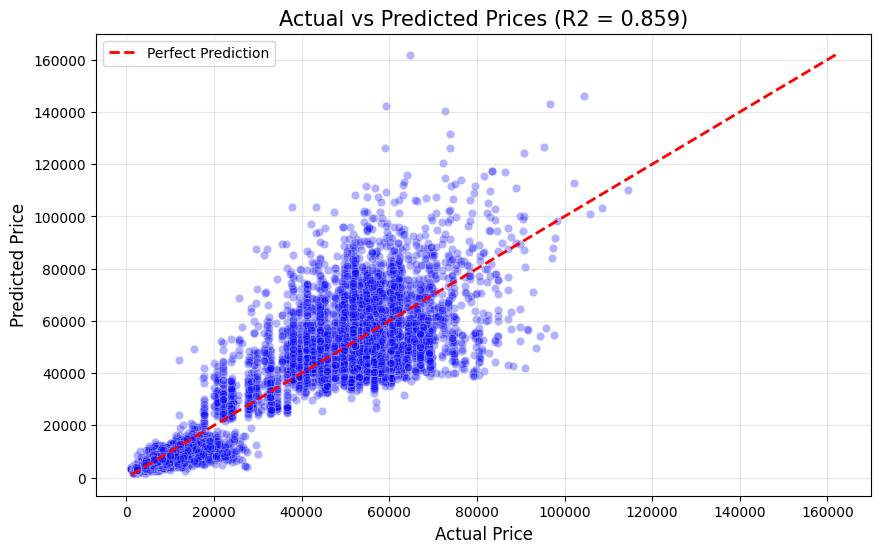

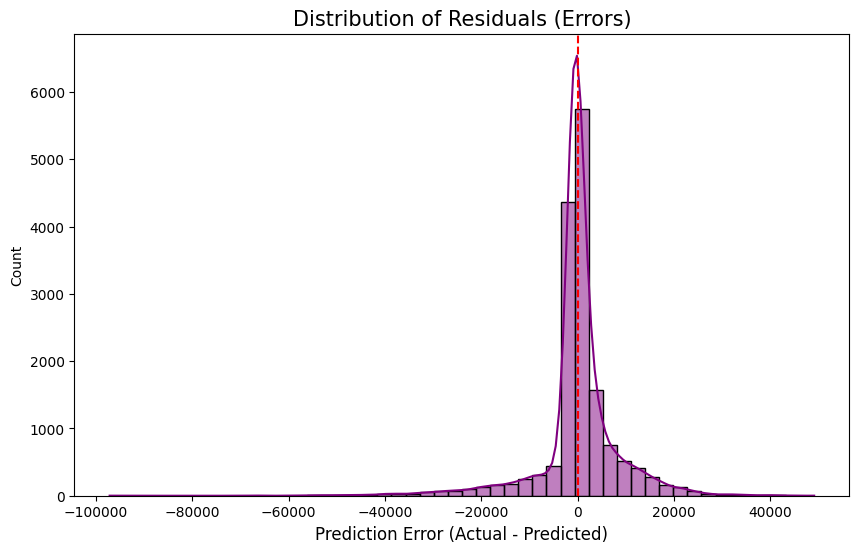


[Interpretation Tip]
1. Scatter Plot: The closer the blue dots are to the red dashed line, the better the model.
2. Residual Hist: Ideally, this looks like a Bell Curve centered at 0.
   - Skewed Right? The model often under-estimates price.
   - Skewed Left? The model often over-estimates price.


In [24]:
# ==========================================
# 7. VISUALIZATION: Actual vs Predicted (MLR)
# ==========================================
print("\n--- Step 7: Visualization (Actual vs Predicted) ---")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Setup the Plot
plt.figure(figsize=(10, 6))

# 2. Scatter Plot (Actual vs Predicted)
sns.scatterplot(x=actual_test_real, y=pred_test_real_mlr, alpha=0.3, color='blue')

# 3. Ideal Line (The "Perfect Prediction" Diagonal)
# We calculate min/max to ensure the line covers the whole plot
min_val = min(min(actual_test_real), min(pred_test_real_mlr))
max_val = max(max(actual_test_real), max(pred_test_real_mlr))

plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

# 4. Labels & Title
plt.title(f'Actual vs Predicted Prices (R2 = {test_r2_mlr:.3f})', fontsize=15)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- OPTIONAL: Residual Plot ---
# We use .values.flatten() to ensure safe subtraction between Pandas Series and Numpy Array
residuals = actual_test_real.values.flatten() - pred_test_real_mlr.flatten()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.title('Distribution of Residuals (Errors)', fontsize=15)
plt.xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Interpretation Tip
print("\n[Interpretation Tip]")
print("1. Scatter Plot: The closer the blue dots are to the red dashed line, the better the model.")
print("2. Residual Hist: Ideally, this looks like a Bell Curve centered at 0.")
print("   - Skewed Right? The model often under-estimates price.")
print("   - Skewed Left? The model often over-estimates price.")

In [25]:
print("\n--- Step 7b: Checking Independence (Durbin-Watson) ---")
from statsmodels.stats.stattools import durbin_watson

# Calculate Durbin-Watson statistic
# (We reuse the 'residuals' variable you created in the optional section)
dw_score = durbin_watson(residuals)

print(f"Durbin-Watson Statistic: {dw_score:.2f}")

# Interpretation logic
if 1.5 <= dw_score <= 2.5:
    print(">> RESULT: Good! No significant autocorrelation detected (Assumption Met).")
elif dw_score < 1.5:
    print(">> RESULT: Caution - Positive autocorrelation (Errors are correlated).")
else:
    print(">> RESULT: Caution - Negative autocorrelation.")


--- Step 7b: Checking Independence (Durbin-Watson) ---
Durbin-Watson Statistic: 2.00
>> RESULT: Good! No significant autocorrelation detected (Assumption Met).



--- Generating Residuals vs. Fitted Values Plot (MLR) ---


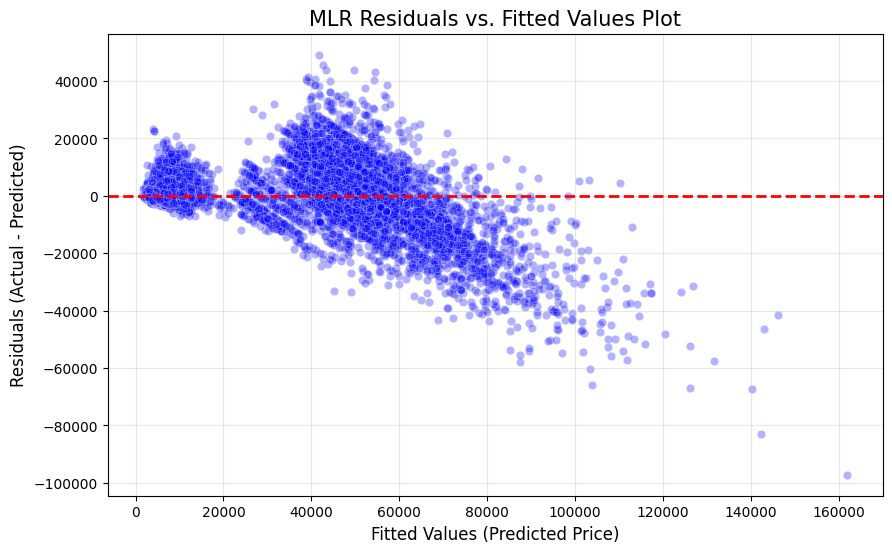


[Interpretation Tip]
1. Random Scatter: Ideally, residuals should be randomly scattered around the red dashed line (y=0).
2. No Pattern: If you see a pattern (e.g., a curve, a funnel shape), it suggests issues like non-linearity or heteroscedasticity.


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n--- Generating Residuals vs. Fitted Values Plot (MLR) ---")

# 1. Setup the Plot
plt.figure(figsize=(10, 6))

# 2. Scatter Plot: Fitted Values (x) vs. Residuals (y)
# pred_test_real_mlr is the fitted value on the real price scale
# residuals is actual_test_real - pred_test_real_mlr
sns.scatterplot(x=pred_test_real_mlr, y=residuals, alpha=0.3, color='blue')

# 3. Add a horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

# 4. Labels & Title
plt.xlabel('Fitted Values (Predicted Price)', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.title('MLR Residuals vs. Fitted Values Plot', fontsize=15)
plt.grid(True, alpha=0.3)

# 6. Display the plot
plt.show()

print("\n[Interpretation Tip]")
print("1. Random Scatter: Ideally, residuals should be randomly scattered around the red dashed line (y=0).")
print("2. No Pattern: If you see a pattern (e.g., a curve, a funnel shape), it suggests issues like non-linearity or heteroscedasticity.")


--- Generating Q-Q Plot of Residuals (MLR) ---


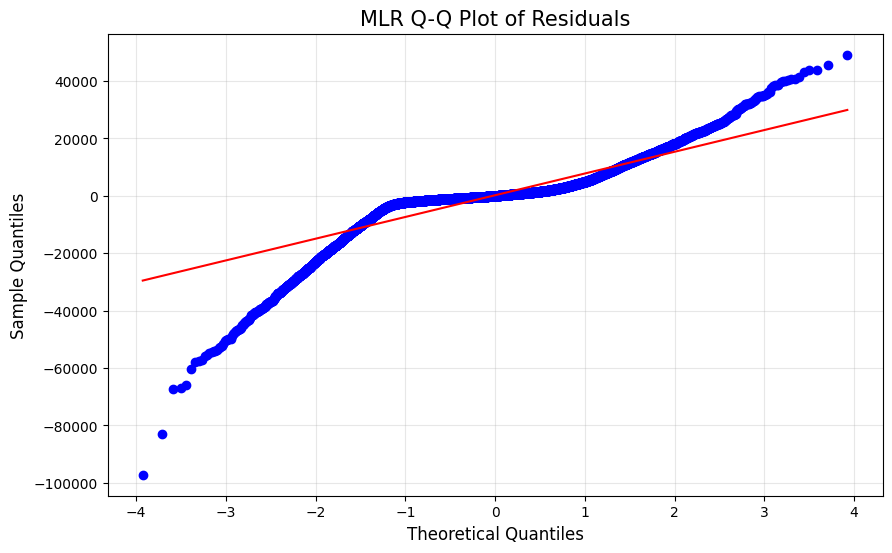


[Interpretation Tip]
1. Normal Distribution: If residuals are normally distributed, the points will closely follow the straight line.
2. Deviations: Deviations from the line (especially at the tails) indicate non-normality.


In [27]:
import matplotlib.pyplot as plt
import scipy.stats as stats

print("\n--- Generating Q-Q Plot of Residuals (MLR) ---")

# 1. Setup the Plot
plt.figure(figsize=(10, 6))

# 2. Create Q-Q plot
# residuals is already defined from previous steps
stats.probplot(residuals, plot=plt)

# 3. Labels & Title
plt.title('MLR Q-Q Plot of Residuals', fontsize=15)
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles', fontsize=12)
plt.grid(True, alpha=0.3)

# 4. Display the plot
plt.show()

print("\n[Interpretation Tip]")
print("1. Normal Distribution: If residuals are normally distributed, the points will closely follow the straight line.")
print("2. Deviations: Deviations from the line (especially at the tails) indicate non-normality.")


In [28]:
# ==========================================
# 9. LASSO REGRESSION (Feature Selection Model)
# ==========================================
print("\n--- Step 9: Lasso Regression (Feature Selection) ---")
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Use the Pre-Scaled Linear Data (From Step 4)
# We do not need to drop or scale anything again. It is already perfect.
X_train_lasso = X_train_linear_scaled
X_eval_lasso = X_eval_linear_scaled

# 2. Train LassoCV
# (CV=5 means it tries 5 different splits to find the perfect 'Alpha' penalty)
print("Training Lasso Model... (Finding best Alpha)")
lasso_model = LassoCV(cv=5, random_state=42, max_iter=10000, n_jobs=-1)
lasso_model.fit(X_train_lasso, y_train)

# 3. Evaluate on Evaluation Set
pred_log_lasso = lasso_model.predict(X_eval_lasso)

# Inverse Log for Real Error
pred_real_lasso = np.expm1(pred_log_lasso)
actual_real_lasso = np.expm1(y_eval)

mae_lasso = mean_absolute_error(actual_real_lasso, pred_real_lasso)
rmse_lasso = np.sqrt(mean_squared_error(actual_real_lasso, pred_real_lasso))
r2_lasso = r2_score(actual_real_lasso, pred_real_lasso)

print(f"\n--- Lasso Performance (on Test Set) ---")
print(f"MAE:      {mae_lasso:.2f}")
print(f"RMSE:     {rmse_lasso:.2f}")
print(f"R2 Score: {r2_lasso:.4f}")

# 4. CHECK DROPPED FEATURES (The "Story" Part)
# Lasso sets the coefficient of useless features to exactly 0
# Since X_train_lasso is a DataFrame (from Step 4), we can get column names directly
coef_series = pd.Series(lasso_model.coef_, index=X_train_lasso.columns)
dropped_features = coef_series[coef_series == 0]

if len(dropped_features) > 0:
    print(f"\n[ Feature Selection Results ]")
    print(f" -> Lasso DROPPED {len(dropped_features)} Features (Deemed Irrelevant):")
    # Print just the first 10 to save space if there are many
    print(f"    {dropped_features.index.tolist()[:10]} ...")
else:
    print("\n -> Lasso kept all features (All contain useful signal).")


--- Step 9: Lasso Regression (Feature Selection) ---
Training Lasso Model... (Finding best Alpha)

--- Lasso Performance (on Test Set) ---
MAE:      4657.97
RMSE:     8449.51
R2 Score: 0.8611

[ Feature Selection Results ]
 -> Lasso DROPPED 2 Features (Deemed Irrelevant):
    ['arrival_time_Late_Night', 'route_Chennai_Delhi'] ...


In [43]:
# ==========================================
# LASSO Model Performance Table (UPDATED)
# ==========================================
print("\n--- Lasso Model Performance ---")

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Helper function for MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

# Prepare actual values in real scale
actual_train_real = np.expm1(y_train)
actual_test_real = np.expm1(y_eval)

# --- Lasso Model Evaluation ---
# We use the model and scaled data from Step 9 directly.

# 1. Predictions (Use SCALED LINEAR data)
pred_train_log_lasso = lasso_model.predict(X_train_linear_scaled)
pred_test_log_lasso = lasso_model.predict(X_eval_linear_scaled)

# 2. Inverse transform to real scale
pred_train_real_lasso = np.expm1(pred_train_log_lasso)
pred_test_real_lasso = np.expm1(pred_test_log_lasso)

# 3. Metrics Calculation
train_rmse_lasso = np.sqrt(mean_squared_error(actual_train_real, pred_train_real_lasso))
train_r2_lasso = r2_score(actual_train_real, pred_train_real_lasso)
train_mape_lasso = calculate_mape(actual_train_real, pred_train_real_lasso)

test_rmse_lasso = np.sqrt(mean_squared_error(actual_test_real, pred_test_real_lasso))
test_r2_lasso = r2_score(actual_test_real, pred_test_real_lasso)
test_mape_lasso = calculate_mape(actual_test_real, pred_test_real_lasso)

# Calculate Adjusted R2 Score for Lasso
n_train = X_train_linear_scaled.shape[0]
# For Lasso, 'p' is the number of features with NON-ZERO coefficients
p_lasso_train = np.sum(lasso_model.coef_ != 0)

if (n_train - p_lasso_train - 1) > 0:
    adjusted_r2_train_lasso = 1 - (1 - train_r2_lasso) * (n_train - 1) / (n_train - p_lasso_train - 1)
else:
    adjusted_r2_train_lasso = np.nan

# 4. Compile results
lasso_performance_row = {
    'Model Name': 'Lasso',
    'Train RMSE': train_rmse_lasso,
    'Train MAPE': train_mape_lasso,
    'Test RMSE': test_rmse_lasso,
    'Test MAPE': test_mape_lasso,
    'Adjusted R2 Score': adjusted_r2_train_lasso
}

df_lasso_performance = pd.DataFrame([lasso_performance_row])
pd.options.display.float_format = '{:,.2f}'.format

display(df_lasso_performance)


--- Lasso Model Performance ---


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,Lasso,"8,430.95",25.17,"8,449.51",25.00,0.86


In [30]:
print("\n--- Step 10: Ridge Regression Model Building ---")
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Instantiate and Train Ridge Model
# X_train_linear_scaled and y_train are already prepared from previous steps
ridge_model = Ridge(alpha=1.0, random_state=42) # Start with alpha=1.0, can be tuned
ridge_model.fit(X_train_linear_scaled, y_train)

# 2. Make Predictions on the Validation Set
pred_log_ridge = ridge_model.predict(X_eval_linear_scaled)

# 3. Inverse Transform for Real Error
pred_real_ridge = np.expm1(pred_log_ridge)
actual_real_ridge = np.expm1(y_eval)

# 4. Calculate and Print Metrics
mae_ridge = mean_absolute_error(actual_real_ridge, pred_real_ridge)
rmse_ridge = np.sqrt(mean_squared_error(actual_real_ridge, pred_real_ridge))
r2_ridge = r2_score(actual_real_ridge, pred_real_ridge)

print(f"\n--- Ridge Performance (on Validation Set) ---")
print(f"MAE:      {mae_ridge:.2f}")
print(f"RMSE:     {rmse_ridge:.2f}")
print(f"R2 Score: {r2_ridge:.4f}")


--- Step 10: Ridge Regression Model Building ---

--- Ridge Performance (on Validation Set) ---
MAE:      4670.23
RMSE:     8496.70
R2 Score: 0.8595


In [31]:
print("\n--- Step 11: Elastic Net Regression Model Building ---")
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Instantiate and Train ElasticNet Model
# X_train_linear_scaled and y_train are already prepared from previous steps
# Start with alpha=1.0 and l1_ratio=0.5 (equal mix of L1 and L2)
elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic_net_model.fit(X_train_linear_scaled, y_train)

# 2. Make Predictions on the Validation Set
pred_log_elastic_net = elastic_net_model.predict(X_eval_linear_scaled)

# 3. Inverse Transform for Real Error
pred_real_elastic_net = np.expm1(pred_log_elastic_net)
actual_real_elastic_net = np.expm1(y_eval)

# 4. Calculate and Print Metrics
mae_elastic_net = mean_absolute_error(actual_real_elastic_net, pred_real_elastic_net)
rmse_elastic_net = np.sqrt(mean_squared_error(actual_real_elastic_net, pred_real_elastic_net))
r2_elastic_net = r2_score(actual_real_elastic_net, pred_real_elastic_net)

print(f"\n--- Elastic Net Performance (on Validation Set) ---")
print(f"MAE:      {mae_elastic_net:.2f}")
print(f"RMSE:     {rmse_elastic_net:.2f}")
print(f"R2 Score: {r2_elastic_net:.4f}")


--- Step 11: Elastic Net Regression Model Building ---

--- Elastic Net Performance (on Validation Set) ---
MAE:      13223.58
RMSE:     20541.49
R2 Score: 0.1788


In [42]:
print("\n--- Ridge Model Performance Table ---")

# Helper function for MAPE (already defined, but good to ensure context)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

# Prepare actual values in real scale (from previous steps)
# actual_train_real and actual_test_real are already available

# --- Ridge Model Evaluation ---

# 1. Predictions (Use SCALED LINEAR data)
pred_train_log_ridge = ridge_model.predict(X_train_linear_scaled)
pred_test_log_ridge = ridge_model.predict(X_eval_linear_scaled)

# 2. Inverse transform to real scale
pred_train_real_ridge = np.expm1(pred_train_log_ridge)
pred_test_real_ridge = np.expm1(pred_test_log_ridge)

# 3. Metrics Calculation
train_rmse_ridge = np.sqrt(mean_squared_error(actual_train_real, pred_train_real_ridge))
train_r2_ridge = r2_score(actual_train_real, pred_train_real_ridge)
train_mape_ridge = calculate_mape(actual_train_real, pred_train_real_ridge)

test_rmse_ridge = np.sqrt(mean_squared_error(actual_test_real, pred_test_real_ridge))
test_r2_ridge = r2_score(actual_test_real, pred_test_real_ridge)
test_mape_ridge = calculate_mape(actual_test_real, pred_test_real_ridge)

# Calculate Adjusted R2 Score for Ridge
n_train = X_train_linear_scaled.shape[0]
p_train = X_train_linear_scaled.shape[1] # For Ridge, all features are typically kept

if (n_train - p_train - 1) > 0:
    adjusted_r2_train_ridge = 1 - (1 - train_r2_ridge) * (n_train - 1) / (n_train - p_train - 1)
else:
    adjusted_r2_train_ridge = np.nan # Or handle appropriately if n_train is too small

# 4. Compile results
ridge_performance_row = {
    'Model Name': 'Ridge',
    'Train RMSE': train_rmse_ridge,
    'Train MAPE': train_mape_ridge,
    'Test RMSE': test_rmse_ridge,
    'Test MAPE': test_mape_ridge,
    'Adjusted R2 Score': adjusted_r2_train_ridge
}

df_ridge_performance = pd.DataFrame([ridge_performance_row])

display(df_ridge_performance)


--- Ridge Model Performance Table ---


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,Ridge,"8,476.57",25.11,"8,496.70",24.95,0.86


In [33]:
print("\n--- Elastic Net Model Performance Table ---")

# Helper function for MAPE (already defined)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

# Prepare actual values in real scale (from previous steps)
# actual_train_real and actual_test_real are already available

# --- Elastic Net Model Evaluation ---

# 1. Predictions (Use SCALED LINEAR data)
pred_train_log_elastic_net = elastic_net_model.predict(X_train_linear_scaled)
pred_test_log_elastic_net = elastic_net_model.predict(X_eval_linear_scaled)

# 2. Inverse transform to real scale
pred_train_real_elastic_net = np.expm1(pred_train_log_elastic_net)
pred_test_real_elastic_net = np.expm1(pred_test_log_elastic_net)

# 3. Metrics Calculation
train_rmse_elastic_net = np.sqrt(mean_squared_error(actual_train_real, pred_train_real_elastic_net))
train_r2_elastic_net = r2_score(actual_train_real, pred_train_real_elastic_net)
train_mape_elastic_net = calculate_mape(actual_train_real, pred_train_real_elastic_net)

test_rmse_elastic_net = np.sqrt(mean_squared_error(actual_test_real, pred_test_real_elastic_net))
test_r2_elastic_net = r2_score(actual_test_real, pred_test_real_elastic_net)
test_mape_elastic_net = calculate_mape(actual_test_real, pred_test_real_elastic_net)

# Calculate Adjusted R2 Score for Elastic Net
n_train = X_train_linear_scaled.shape[0]
# For Elastic Net, 'p' is the number of features with NON-ZERO coefficients
p_elastic_net_train = np.sum(elastic_net_model.coef_ != 0) # Only include non-zero coefficients

if (n_train - p_elastic_net_train - 1) > 0:
    adjusted_r2_train_elastic_net = 1 - (1 - train_r2_elastic_net) * (n_train - 1) / (n_train - p_elastic_net_train - 1)
else:
    adjusted_r2_train_elastic_net = np.nan # Or handle appropriately if n_train is too small

# 4. Compile results
elastic_net_performance_row = {
    'Model Name': 'Elastic Net Regression',
    'Train RMSE': train_rmse_elastic_net,
    'Train MAPE': train_mape_elastic_net,
    'Test RMSE': test_rmse_elastic_net,
    'Test MAPE': test_mape_elastic_net,
    'Adjusted R2 Score': adjusted_r2_train_elastic_net
}

df_elastic_net_performance = pd.DataFrame([elastic_net_performance_row])

display(df_elastic_net_performance)



--- Elastic Net Model Performance Table ---


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,Elastic Net Regression,"20,535.30",81.67,"20,541.49",80.05,0.18


In [37]:
print("\n--- Tuning Elastic Net Model with GridSearchCV ---")

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

# Initialize ElasticNet model (use max_iter to prevent convergence warnings during grid search)
elastic_net = ElasticNet(random_state=42, max_iter=10000)

# Setup GridSearchCV
# We use the X_train_linear_scaled and y_train from previous steps
grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid_elastic_net,
    scoring='neg_mean_squared_error', # Using negative MSE as GridSearchCV tries to maximize score
    cv=5, # 5-fold cross-validation
    n_jobs=-1, # Use all available cores
    verbose=1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_linear_scaled, y_train)

# Get the best parameters and best score
best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']
best_rmse = np.sqrt(-grid_search.best_score_)

print(f"\nBest Hyperparameters found: Alpha = {best_alpha}, L1_ratio = {best_l1_ratio}")
print(f"Best RMSE from GridSearchCV (Cross-Validation): {best_rmse:.2f}")

# Store the best model
elastic_net_tuned_model = grid_search.best_estimator_

print("Elastic Net model tuned successfully and best estimator stored.")


--- Tuning Elastic Net Model with GridSearchCV ---
Fitting 5 folds for each of 35 candidates, totalling 175 fits

Best Hyperparameters found: Alpha = 0.001, L1_ratio = 0.1
Best RMSE from GridSearchCV (Cross-Validation): 0.31
Elastic Net model tuned successfully and best estimator stored.


In [41]:
print("\n--- Tuned Elastic Net Model Performance Table ---")

# Helper function for MAPE (already defined, but good to ensure context)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

# Prepare actual values in real scale (from previous steps)
# actual_train_real and actual_test_real are already available

# --- Tuned Elastic Net Model Evaluation ---

# 1. Predictions (Use SCALED LINEAR data with the tuned model)
pred_train_log_elastic_net_tuned = elastic_net_tuned_model.predict(X_train_linear_scaled)
pred_test_log_elastic_net_tuned = elastic_net_tuned_model.predict(X_eval_linear_scaled)

# 2. Inverse transform to real scale
pred_train_real_elastic_net_tuned = np.expm1(pred_train_log_elastic_net_tuned)
pred_test_real_elastic_net_tuned = np.expm1(pred_test_log_elastic_net_tuned)

# 3. Metrics Calculation
train_rmse_elastic_net_tuned = np.sqrt(mean_squared_error(actual_train_real, pred_train_real_elastic_net_tuned))
train_r2_elastic_net_tuned = r2_score(actual_train_real, pred_train_real_elastic_net_tuned)
train_mape_elastic_net_tuned = calculate_mape(actual_train_real, pred_train_real_elastic_net_tuned)

test_rmse_elastic_net_tuned = np.sqrt(mean_squared_error(actual_test_real, pred_test_real_elastic_net_tuned))
test_r2_elastic_net_tuned = r2_score(actual_test_real, pred_test_real_elastic_net_tuned)
test_mape_elastic_net_tuned = calculate_mape(actual_test_real, pred_test_real_elastic_net_tuned)

# Calculate Adjusted R2 Score for Tuned Elastic Net
n_train = X_train_linear_scaled.shape[0]
# For Elastic Net, 'p' is the number of features with NON-ZERO coefficients
p_elastic_net_tuned_train = np.sum(elastic_net_tuned_model.coef_ != 0)

if (n_train - p_elastic_net_tuned_train - 1) > 0:
    adjusted_r2_train_elastic_net_tuned = 1 - (1 - train_r2_elastic_net_tuned) * (n_train - 1) / (n_train - p_elastic_net_tuned_train - 1)
else:
    adjusted_r2_train_elastic_net_tuned = np.nan # Or handle appropriately if n_train is too small

# 4. Compile results
elastic_net_tuned_performance_row = {
    'Model Name': 'Elastic Net',
    'Train RMSE': train_rmse_elastic_net_tuned,
    'Train MAPE': train_mape_elastic_net_tuned,
    'Test RMSE': test_rmse_elastic_net_tuned,
    'Test MAPE': test_mape_elastic_net_tuned,
    'Adjusted R2 Score': adjusted_r2_train_elastic_net_tuned
}

df_elastic_net_tuned_performance = pd.DataFrame([elastic_net_tuned_performance_row])

# Ensure consistent float format for display
pd.options.display.float_format = '{:,.2f}'.format

display(df_elastic_net_tuned_performance)



--- Tuned Elastic Net Model Performance Table ---


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,Elastic Net,"8,460.50",25.13,"8,480.20",24.97,0.86


In [44]:
print("\n--- Step 12: Performance Comparison Table ---")

# Combine all performance DataFrames into one
all_models_performance = pd.concat([
    df_lasso_performance,
    df_ridge_performance,
    df_elastic_net_tuned_performance # Add the tuned Elastic Net performance
]).reset_index(drop=True)

# Display the comparison table
print("\nOverall Model Performance Comparison:")
display(all_models_performance)


--- Step 12: Performance Comparison Table ---

Overall Model Performance Comparison:


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,Lasso,"8,430.95",25.17,"8,449.51",25.00,0.86
1,Ridge,"8,476.57",25.11,"8,496.70",24.95,0.86
2,Elastic Net,"8,460.50",25.13,"8,480.20",24.97,0.86
